# problem
We are working with a large offline retailer that specializes in Fast Moving Consumer Goods (FMCGs), including products like pretzels, frozen pizza, boxed cereal, and mouthwash. The retailer acquires these products from various manufacturers, stores them in inventory, and distributes them to its stores based on customer demand. However, the retailer is currently facing substantial business losses.
## dataset
we have weekly sales data that includes

**product info**

* UPC (Universal Product Code): A unique identifier for each product.
* Description: Product details.
* Manufacturer: The company producing the product.
* Category and Sub-category: Product classification (e.g., snacks, beverages).
* Product Size: The quantity or volume of the product (e.g., 500g, 1L).

**Sales info**

Sales data, tracked weekly for each product at each store, includes:
* Week-End Date: Time-based details to monitor sales trends.
* Discounts: Offers and in-store promotional activities.
* DISPLAY: product was a part of in-store promotional display
* FEATURE: product was in in-store circular
* UNITS: units sold (target)

**store info**

* Store ID: Unique identifiers for each store.
* STORE_NAME: Name of store
* ADDRESS_CITY_NAME: city
* ADDRESS_STATE_PROV_CODE: state
* SALES_AREA_SIZE_NUM: square footage of store
* AVG_WEEKLY_BASKETS: average weekly baskets sold in the store

### We joined these 3 tapels in BigQuery

## solution
Prevent overstocking and understocking of goods to reduce buisness loss by predicting the demand for packed items in each store for the next week

In [1]:

#importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from math import sqrt
from statistics import mean, stdev

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd

# Initialize BigQuery client
client = bigquery.Client(project='project2-436708')


In [3]:
#2-load the dataset

query = """
SELECT *
FROM `project2-436708.my_dataset.complete_data`
"""

# Execute the query and load data into a DataFrame
data = client.query(query).to_dataframe()


In [4]:
data.head()

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE,WEEK_END_DATE,UNITS,PRICE,BASE_PRICE,FEATURE,DISPLAY,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,1111085319,PL HONEY NUT TOASTD OATS,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,12.25 OZ,2009-07-15,7,1.75,1.75,0,0,13827,BEAUMONT,BEAUMONT,TX,MAINSTREAM,<NA>,50766,26001
1,1111085319,PL HONEY NUT TOASTD OATS,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,12.25 OZ,2009-09-23,12,1.75,1.75,0,0,13827,BEAUMONT,BEAUMONT,TX,MAINSTREAM,<NA>,50766,26001
2,1111085319,PL HONEY NUT TOASTD OATS,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,12.25 OZ,2010-06-16,12,1.75,1.75,0,0,13827,BEAUMONT,BEAUMONT,TX,MAINSTREAM,<NA>,50766,26001
3,1111085319,PL HONEY NUT TOASTD OATS,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,12.25 OZ,2011-04-27,4,1.75,1.75,0,0,13827,BEAUMONT,BEAUMONT,TX,MAINSTREAM,<NA>,50766,26001
4,1111085319,PL HONEY NUT TOASTD OATS,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,12.25 OZ,2011-09-14,11,1.75,1.75,0,0,13827,BEAUMONT,BEAUMONT,TX,MAINSTREAM,<NA>,50766,26001


In [ ]:
data.shape

(232287, 20)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232287 entries, 0 to 232286
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   UPC                      232287 non-null  Int64  
 1   DESCRIPTION              232287 non-null  object 
 2   MANUFACTURER             232287 non-null  object 
 3   CATEGORY                 232287 non-null  object 
 4   SUB_CATEGORY             232287 non-null  object 
 5   PRODUCT_SIZE             232287 non-null  object 
 6   WEEK_END_DATE            232287 non-null  dbdate 
 7   UNITS                    232287 non-null  Int64  
 8   PRICE                    232284 non-null  float64
 9   BASE_PRICE               232275 non-null  float64
 10  FEATURE                  232287 non-null  Int64  
 11  DISPLAY                  232287 non-null  Int64  
 12  STORE_ID                 232287 non-null  Int64  
 13  STORE_NAME               232287 non-null  object 
 14  ADDR

In [ ]:
data.isna().sum()

,0
UPC,0
DESCRIPTION,0
MANUFACTURER,0
CATEGORY,0
SUB_CATEGORY,0
PRODUCT_SIZE,0
WEEK_END_DATE,0
UNITS,0
PRICE,3
BASE_PRICE,12


### Impute the missing values

In [5]:
data['BASE_PRICE']=data['BASE_PRICE'].fillna(data['BASE_PRICE'].mean())

In [6]:
data['PRICE']=data['PRICE'].fillna(data['PRICE'].mean())

In [7]:
data=data.drop('PARKING_SPACE_QTY', axis=1)

In [ ]:
data.describe()

,UPC,UNITS,PRICE,BASE_PRICE,FEATURE,DISPLAY,STORE_ID,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
count,232287.0,232287.0,232287.000000,232287.000000,232287.0,232287.0,232287.0,232287.0,232287.0
mean,3633351918.145294,28.063525,3.131375,3.345204,0.099889,0.135001,14676.437463,50723.160315,25106.633165
std,4840890907.398004,35.954341,1.562361,1.678138,0.299853,0.341725,8841.382984,13520.532955,9016.227324
min,1111009477.0,0.0,0.580000,0.860000,0.0,0.0,367.0,10788.0,10435.0
25%,1111085345.0,9.0,1.880000,1.950000,0.0,0.0,6187.0,46073.0,18197.0
50%,1600027528.0,18.0,2.890000,2.990000,0.0,0.0,15541.0,48813.0,25289.0
75%,3800039118.0,34.0,3.870000,4.080000,0.0,0.0,23067.0,55663.0,29916.0
max,31254742835.0,1800.0,7.890000,7.890000,1.0,1.0,29159.0,86517.0,54053.0


In [8]:
data['WEEK_END_DATE']=pd.to_datetime(data['WEEK_END_DATE'])
#2-set the date as an index
data.index=data.WEEK_END_DATE
data = data.sort_index(ascending=True)

### Is there any missing weeks?

In [ ]:
(data['WEEK_END_DATE'].max() - data['WEEK_END_DATE'].min())/7

Timedelta('141 days 00:00:00')

In [ ]:
# Check the number of unique dates
num_unique_dates = data['WEEK_END_DATE'].nunique()
print(f"Number of unique dates: {num_unique_dates}")


Number of unique dates: 142


* The data is for 142 weeks, based on the number of unique weekend dates in the file.
* No dates are missing from this period.

In [ ]:
#how many products we have?
number_of_products='''
select count (DISTINCT UPC) FROM `my_dataset.Cleaned_dataset`
'''
number_of_products=client.query(number_of_products).to_dataframe()

In [ ]:
number_of_products

,f0_
0,30


In [ ]:
# How many stores we are sealing with?
number_of_stores='''
select count (DISTINCT STORE_ID) FROM `my_dataset.complete_data`
'''
number_of_stores=client.query(number_of_stores).to_dataframe()

In [ ]:
number_of_stores

,f0_
0,76


we have 30 products through 76 diffrent stores

# Time series analysis

### Sales Trend Over Time
**how sales change over time (are they increasing, decreasing, or staying flat?**

### Sales by year and month

In [ ]:

sales_by_year="""
select sum(UNITS) as sales, EXTRACT(YEAR FROM WEEK_END_DATE) as year from `my_dataset.Cleaned_dataset`group by year
"""
yearly_sales=client.query(sales_by_year).to_dataframe()

In [ ]:
yearly_sales.head()

,sales,year
0,2369906,2009
1,2372849,2010
2,1775411,2011


In [ ]:
sales_by_month="""
select sum(UNITS) as sales, EXTRACT(month FROM WEEK_END_DATE) as month from `my_dataset.Cleaned_dataset`group by month order by month
"""
monthly_sales=client.query(sales_by_month).to_dataframe()
monthly_sales

,sales,month
0,510533,1
1,635173,2
2,626382,3
3,545823,4
4,614206,5
5,616433,6
6,568706,7
7,590958,8
8,594252,9
9,353164,10


In [ ]:
#we will take a closer look at each year seperatly

sales_2009_query='''
SELECT
    EXTRACT(MONTH FROM WEEK_END_DATE) AS month,
    SUM(UNITS) AS total_sales
FROM `my_dataset.Cleaned_dataset`
WHERE EXTRACT(YEAR FROM WEEK_END_DATE) = 2009
GROUP BY month
ORDER BY month;
'''
sales_2009=client.query(sales_2009_query).to_dataframe()

sales_2010_query='''
SELECT
    EXTRACT(MONTH FROM WEEK_END_DATE) AS month,
    SUM(UNITS) AS total_sales
FROM `my_dataset.Cleaned_dataset`
WHERE EXTRACT(YEAR FROM WEEK_END_DATE) = 2010
GROUP BY month
ORDER BY month;
'''
sales_2010=client.query(sales_2010_query).to_dataframe()


sales_2011_query='''
SELECT
    EXTRACT(MONTH FROM WEEK_END_DATE) AS month,
    SUM(UNITS) AS total_sales
FROM `my_dataset.Cleaned_dataset`
WHERE EXTRACT(YEAR FROM WEEK_END_DATE) = 2011
GROUP BY month
ORDER BY month;
'''
sales_2011=client.query(sales_2011_query).to_dataframe()

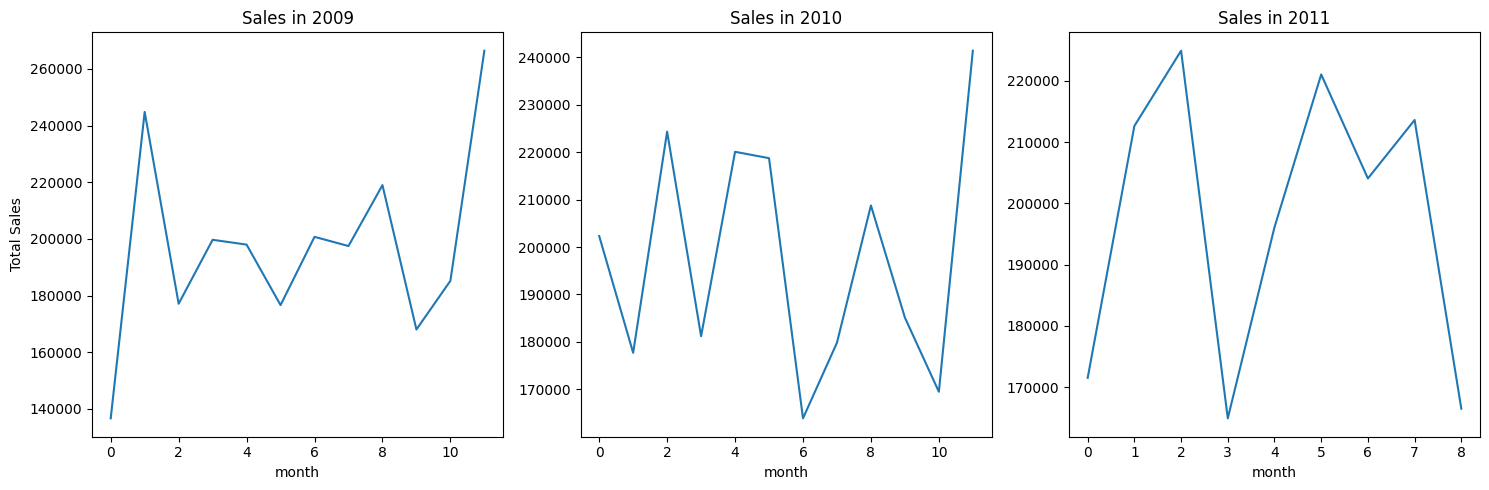

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have dataframes 'sales_2009', 'sales_2010', and 'sales_2011' with total sales
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create 1 row, 3 columns of subplots

# Plot for 2009
axs[0].plot(sales_2009['total_sales'])
axs[0].set_title('Sales in 2009')
axs[0].set_xlabel('month')
axs[0].set_ylabel('Total Sales')

# Plot for 2010
axs[1].plot(sales_2010['total_sales'])
axs[1].set_title('Sales in 2010')
axs[1].set_xlabel('month')

# Plot for 2011
axs[2].plot(sales_2011['total_sales'])
axs[2].set_title('Sales in 2011')
axs[2].set_xlabel('month')

# Adjust layout so titles/labels don't overlap
plt.tight_layout()

# Display the plot
plt.show()

**Seasonal Fluctuations**:
* Each year shows significant fluctuations in sales across the months, indicating that sales are not consistent throughout the year.

**Peak and Trough Months**:
* 2009: Sales peak around the 1st and 11th months and drop significantly around the 3rd and 7th months.
* 2010: Sales are at their highest around the 11th month and lowest in the 1st and 6th months.
* 2011: The 1st and 4th months show high sales, while the 3rd and 8th months exhibit sharp declines.

**Year-over-Year Comparison**:

* Sales in 2009 start relatively high, drop in the middle, and end at a peak.
* 2010 has more volatile ups and downs compared to 2009, with a steep rise towards the end of the year.
* 2011 shows sharper drops and peaks, indicating high variability in sales performance.


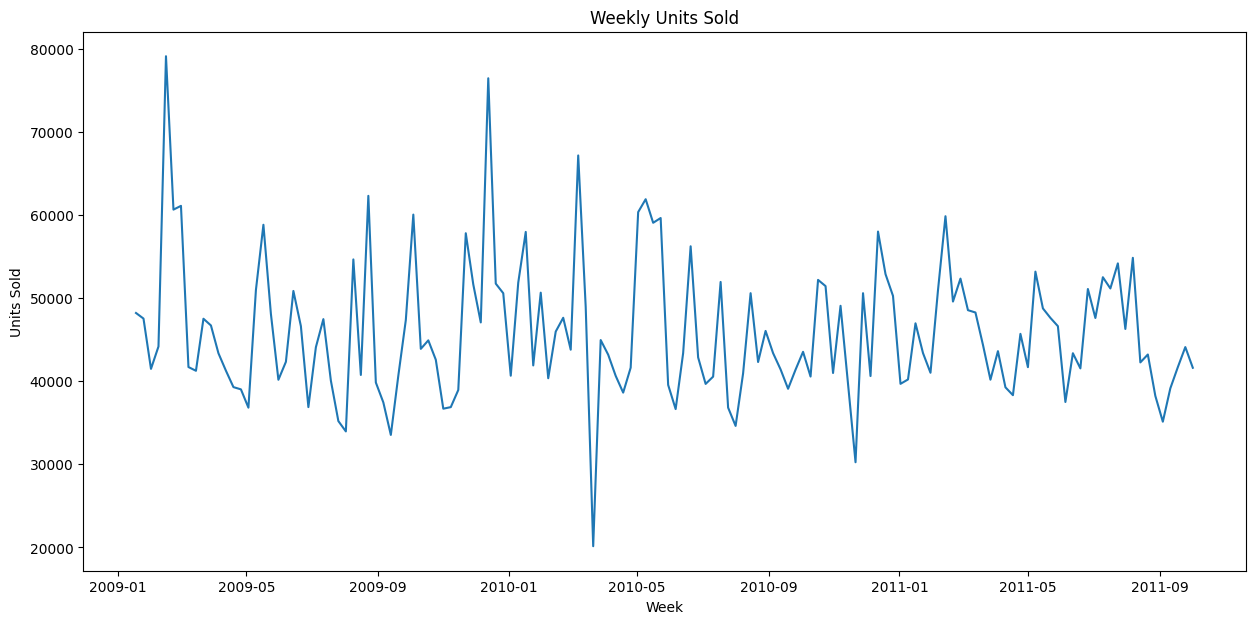

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the index is in datetime format
data.index = pd.to_datetime(data.index)

# Convert 'UNITS' to numeric if necessary
data['UNITS'] = pd.to_numeric(data['UNITS'], errors='coerce')

# Resample by week and sum the units
weekly_data = data['UNITS'].resample('W').sum()

# Plot the resampled weekly data
plt.figure(figsize=(15, 7))
plt.plot(weekly_data.index, weekly_data)
plt.title('Weekly Units Sold')
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.show()


**Key Observations**:
* High Initial Volatility: Early 2009 shows sharp peaks and troughs, with a maximum of nearly 80,000 units sold, followed by a rapid decline.

* Gradual Decline in Peaks: Peak sales decrease over time—from 70,000 in 2009 to below 60,000 by 2011—indicating a slight reduction in demand.

* Significant Dips: Notable drops occur around mid-2010 and early 2011, reaching as low as 20,000 units, but these are temporary with quick recoveries.

* Stabilization Over Time: Sales patterns become more consistent by the end of 2011, showing fewer extreme fluctuations compared to earlier periods

Overall: The data shows high volatility in early 2009, a gradual decline in peak sales, and stabilization by 2011, suggesting a maturing market.

### **week on week growth**

In [ ]:
week_growth_query= '''
SELECT
    WEEK_END_DATE,
    SUM(UNITS) AS total_sales,
    LAG(SUM(UNITS), 1) OVER (ORDER BY WEEK_END_DATE) AS previous_week_sales,
    (SUM(UNITS) - LAG(SUM(UNITS), 1) OVER (ORDER BY WEEK_END_DATE)) / LAG(SUM(UNITS), 1) OVER (ORDER BY WEEK_END_DATE) * 100 AS week_over_week_growth
FROM `my_dataset.Cleaned_dataset`
GROUP BY WEEK_END_DATE
ORDER BY WEEK_END_DATE;
'''
week_growth=client.query(week_growth_query).to_dataframe()

In [ ]:
week_growth

,WEEK_END_DATE,total_sales,previous_week_sales,week_over_week_growth
0,2009-01-14,47962,<NA>,NaN
1,2009-01-21,47361,47962,-1.253075
2,2009-01-28,41363,47361,-12.664429
3,2009-02-04,44044,41363,6.481638
4,2009-02-11,79075,44044,79.536373
...,...,...,...,...
137,2011-08-31,35120,38221,-8.113341
138,2011-09-07,39128,35120,11.412301
139,2011-09-14,41677,39128,6.514516
140,2011-09-21,44093,41677,5.796962


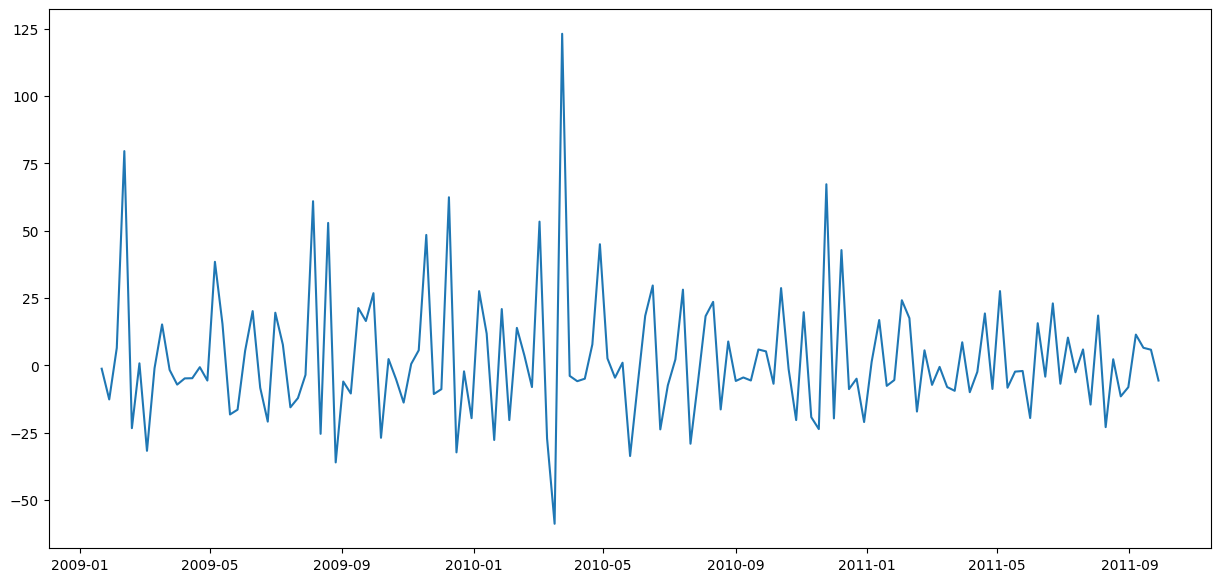

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(week_growth.WEEK_END_DATE, week_growth['week_over_week_growth'])

* High Early Volatility: Sharp fluctuations in 2009, with growth reaching up to +79.5%.
* Negative Growth: Periodic dips like -12.7% in early 2009 and -8.1% in 2011.
* Stabilization: By 2011, week-over-week changes are moderate, indicating more stable performance.

# Hypothisis testing



### Sales at the Product Level




1. **Discount Effect**: Products offered at a discount are more likely to achieve higher sales compared to non-discounted products.

In [24]:
# Create a new column 'discount' where:
# 1 indicates a discount (price < base_price)
# 0 indicates no discount (price >= base_price)
data['discount'] = np.where(data['PRICE'] < data['BASE_PRICE'], 1, 0)

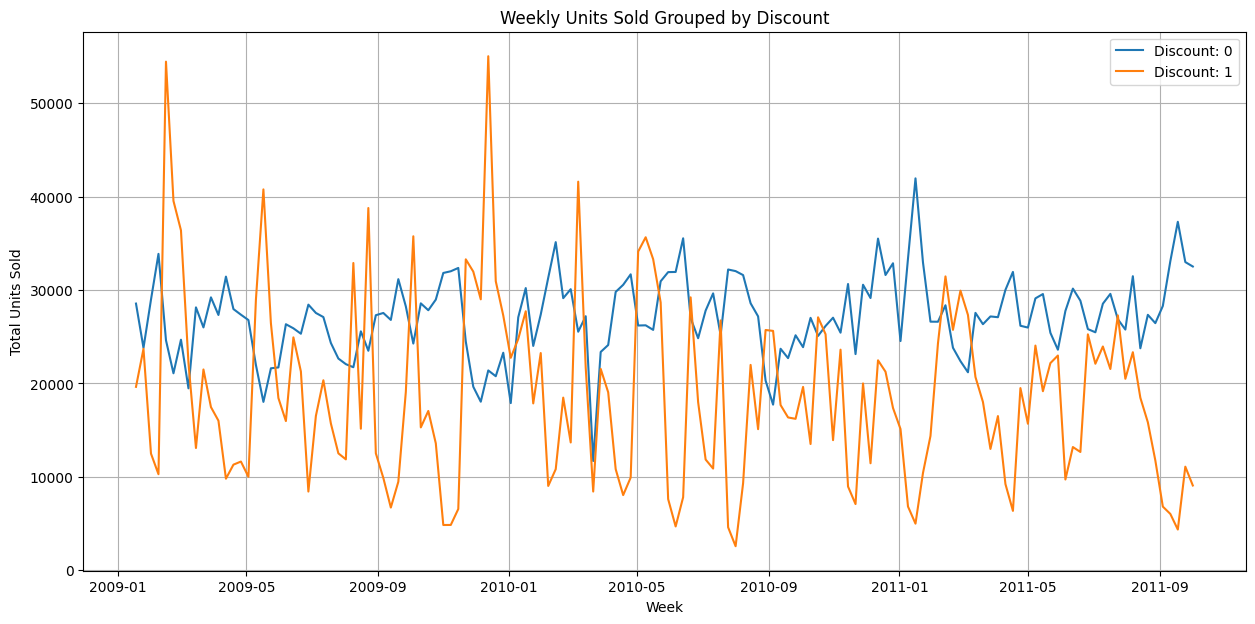

In [32]:
# Group by week and discount, then sum the 'UNITS'
weekly_discount_data = data.groupby([pd.Grouper(freq='W'), 'discount'])['UNITS'].sum().reset_index()

# Rename the 'index' column to a more appropriate name (like 'Week')
weekly_discount_data.rename(columns={'index': 'WEEK_END_DATE'}, inplace=True)

# Create a pivot table to make the plotting easier
pivot_table = weekly_discount_data.pivot(index='WEEK_END_DATE', columns='discount', values='UNITS')

# Plot the weekly data for each discount level
plt.figure(figsize=(15, 7))
for discount in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[discount], label=f'Discount: {discount}')

plt.title('Weekly Units Sold Grouped by Discount')
plt.xlabel('Week')
plt.ylabel('Total Units Sold')
plt.legend()
plt.grid(True)
plt.show()


* **The hypothesis is partially supported**. Products on discount are more likely to sell in the short term, but the effect is not sustained, indicating that while discounts boost immediate sales, their long-term impact is limited compared to stable non-discounted sales.

2. **Product Category**: Products belonging to different categories are likely to have significantly varying sales patterns.


In [ ]:
#group products based on the categories
product_category= '''
select CATEGORY, sum(UNITS) as product from `my_dataset.complete_data` group by CATEGORY order by product desc

'''
grouped_category=client.query(product_category).to_dataframe()

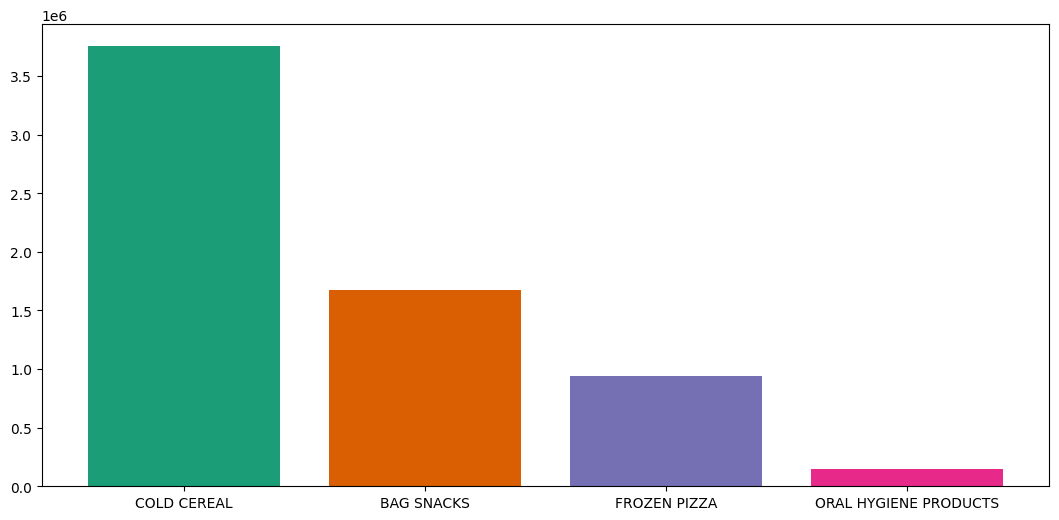

In [ ]:
#grouped_category visulazation
plt.figure(figsize=(13,6))
plt.bar(grouped_category['CATEGORY'],grouped_category['product'], color=sns.palettes.mpl_palette('Dark2') )
plt.show()

* Cold Cereal has the highest sales volume, making it the top-selling category by a significant margin.

* Bag Snacks have less than half the sales of Cold Cereal but still outperform other categories significantly.

* Frozen Pizza and Oral Hygiene Products have much lower sales, with Frozen Pizza.

3. **Sub-Category Impact**: Sales trends are likely to differ significantly across various product sub-categories.


In [ ]:
#group products based on the sub categories
product_subcategory= '''
select SUB_CATEGORY, sum(UNITS) as product from `my_dataset.complete_data` group by SUB_CATEGORY order by product desc

'''
grouped_sub_category=client.query(product_subcategory).to_dataframe()

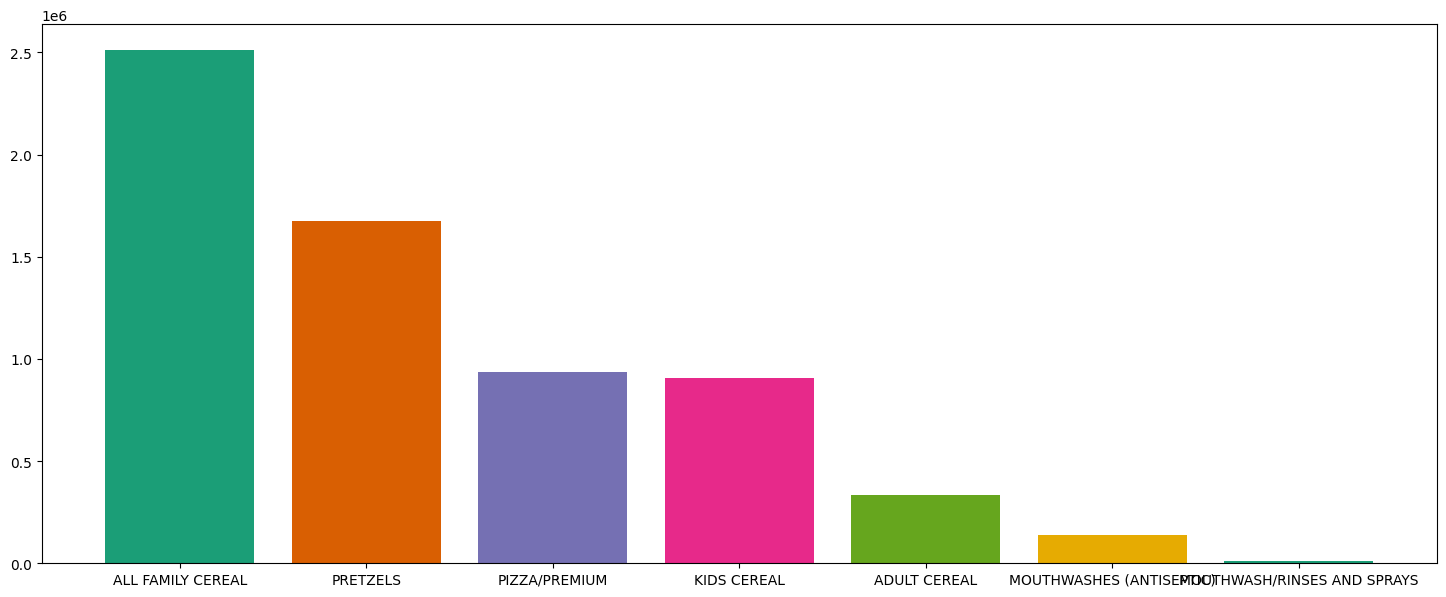

In [ ]:
#grouped_sub_category visulazation
plt.figure(figsize=(18,7))
plt.bar(grouped_sub_category['SUB_CATEGORY'],grouped_sub_category['product'], color=sns.palettes.mpl_palette('Dark2') )
plt.show()

All Family Cereal dominates sales, followed by Pretzels. Premium Pizza and Kids Cereal have mid-level sales, while Adult Cereal and Mouthwashes have limited demand. Mouthwash Rinses and Sprays have the lowest sales, indicating a niche market.

4. **Product Size**: Larger products are expected to sell more compared to smaller ones.

In [33]:
#before we group by product size we will convert the size to the same scale (OZ)
# Function to convert all sizes to OZ
def convert_to_oz(size):
    if 'OZ' in size:
        return float(size.replace(' OZ', ''))
    elif 'ML' in size:
        ml_value = float(size.replace(' ML', ''))
        return ml_value * 0.033814  # Convert ML to OZ
    elif 'LT' in size:
        lt_value = float(size.replace(' LT', ''))
        return lt_value * 33.814  # Convert LT to OZ
    else:
        return None  # Handle any unexpected cases

# Apply the conversion function to the 'size' column
data['PRODUCT_SIZE'] = data['PRODUCT_SIZE'].apply(convert_to_oz)


In [34]:
grouped_size = pd.DataFrame(data)

# Group by size_in_oz and count the number of items for each size
grouped_df = grouped_size.groupby('PRODUCT_SIZE').size().reset_index(name='product_count')

# Sort by the item count in descending order
sorted_df = grouped_df.sort_values(by='product_count', ascending=False)

# Display the sorted DataFrame
sorted_df

,PRODUCT_SIZE,product_count
4,15.000,39706
7,18.000,32203
5,16.000,21443
3,12.250,21426
14,32.700,18743
8,20.000,10789
1,12.000,10786
10,28.300,10767
2,12.200,10766
11,29.600,9989


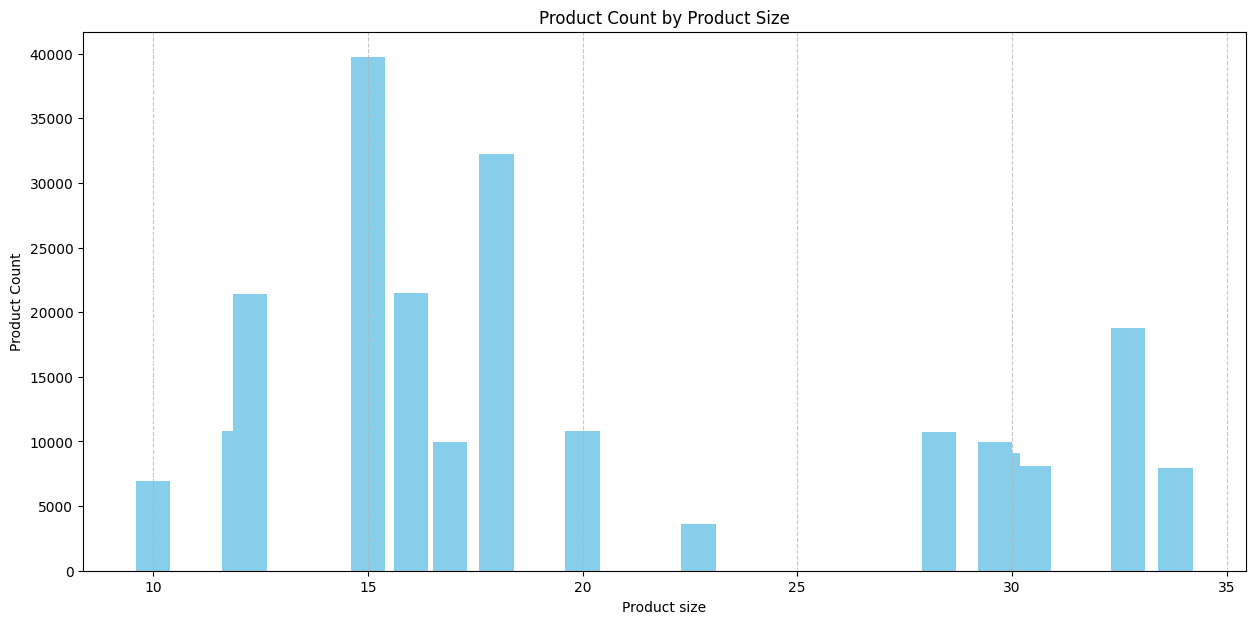

In [39]:
# Plot a horizontal bar chart for better readability
plt.figure(figsize=(15, 7))
plt.bar(sorted_df['PRODUCT_SIZE'], sorted_df['product_count'], color='skyblue')

# Add labels and title
plt.xlabel('Product size')
plt.ylabel('Product Count')
plt.title('Product Count by Product Size')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

The distribution is concentrated around Sizes 15 and 20, with fewer products in the ranges between 20 to 30 and at Size 35. This suggests that mid-sized products are the most popular, while very small or large sizes are less common.


5. **Display vs. Featured products**: Products that are displayed are expected to have higher sales than those simply featured.



In [ ]:
#groub by Display vs. Featured prodducts
grouped_presentation='''
select FEATURE,DISPLAY, sum(UNITS) as Sales
from`my_dataset.complete_data`
 group by FEATURE,DISPLAY
 order by Sales desc
'''
grouped_presentation=client.query(grouped_presentation).to_dataframe()

In [ ]:
grouped_presentation

,FEATURE,DISPLAY,Sales
0,0,0,4267070
1,1,1,950837
2,0,1,851240
3,1,0,449645


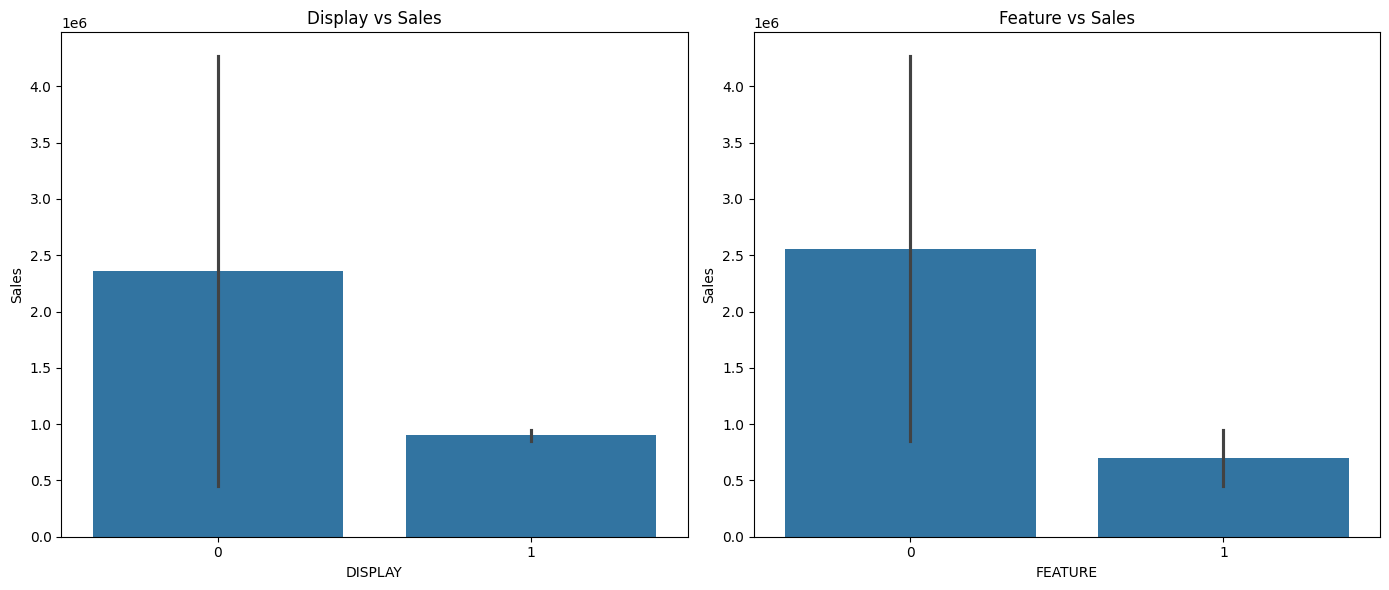

In [ ]:
# Set up the figure and subplots
plt.figure(figsize=(14, 6))  # One figure, bigger width to fit plots

# First subplot: Display vs Sales
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
sns.barplot(x=grouped_presentation['DISPLAY'], y=grouped_presentation['Sales'])
plt.title('Display vs Sales')

# Second subplot: Feature vs Sales
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
sns.barplot(x=grouped_presentation['FEATURE'], y=grouped_presentation['Sales'])
plt.title('Feature vs Sales')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Contrary to expectations, products with displays or features perform worse in terms of sales. This suggests that display or feature strategies may not be effective for this product group and could indicate a need for strategy revision.

6. **Manufacturer**: Well-known brands or manufacturers are expected to have higher sales.

In [ ]:
#group products based on the manafactures
q="""
select sum(UNITS) as product,MANUFACTURER from `my_dataset.Cleaned_dataset` group by MANUFACTURER
"""
groupde_manfactures=client.query(q).to_dataframe()

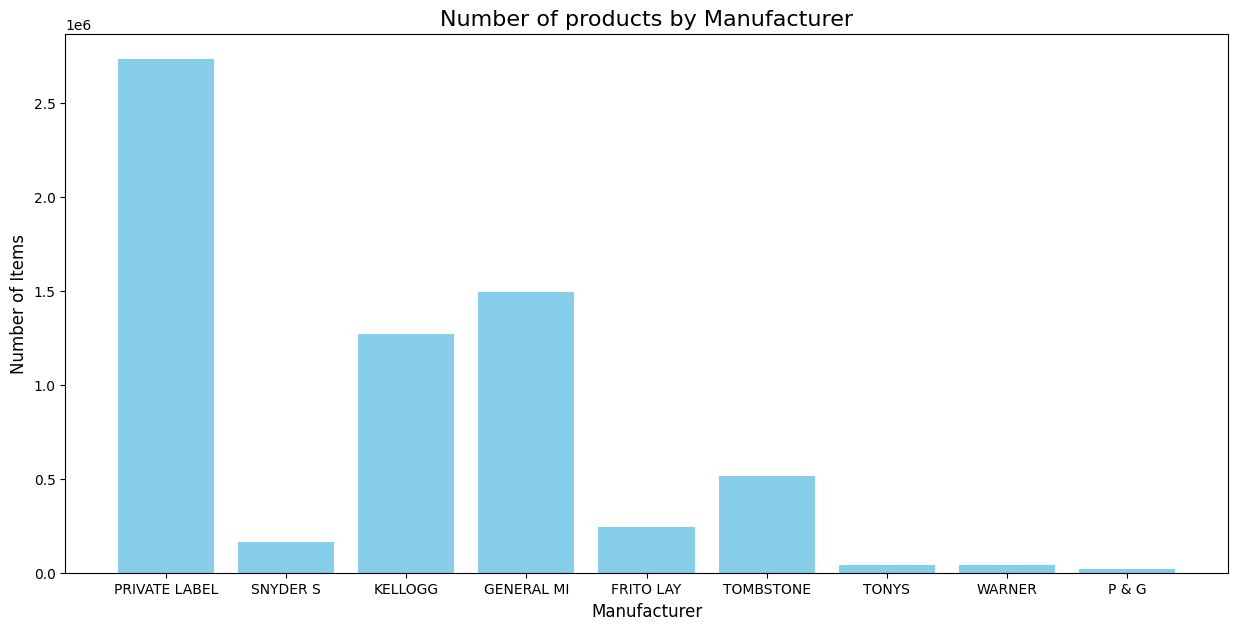

In [ ]:
# Plot a bar chart using matplotlib
plt.figure(figsize=(15, 7))
plt.bar(groupde_manfactures['MANUFACTURER'], groupde_manfactures['product'], color='skyblue')

# Add titles and labels
plt.title('Number of products by Manufacturer', fontsize=16)
plt.xlabel('Manufacturer', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.show()


* The market is dominated by Private Label, with General Mills and Kellogg being the main branded competitors. Smaller players like Frito Lay and Tombstone have a presence, but niche brands hold a minor share in terms of product count.


### Sales at the Store Level



1. **Store Performance across diffrent stores**: Sales patterns are likely to vary widely across different store locations.

In [ ]:
#what store is driving the highst sales
stores_sales='''
select STORE_NAME, sum(UNITS) as Sales
from`my_dataset.complete_data`
group by STORE_NAME
order by Sales desc
'''
stores_sales=client.query(stores_sales).to_dataframe()

In [ ]:
stores_sales

,STORE_NAME,Sales
0,HOUSTON,287156
1,ANDERSON TOWNE CTR,229575
2,MIDDLETOWN,217013
3,CINCINNATI,213418
4,HYDE PARK,181721
...,...,...
67,LANDMARK PLACE S/C,36753
68,NORWOOD,34706
69,NORTHBOROUGH SQ,32779
70,WALNUT HILLS/PEEBLES,21913


**Top-Performing Stores**:
* Houston has the highest sales with 287,156 units, followed by Anderson Towne CTR at 229,575 units.

8 Middletown and Cincinnati are also high-performing stores, each exceeding 200,000 units in sales.

**Mid-Level Stores**:

* Stores like Hyde Park and others show sales ranging between 150,000 to 180,000 units, indicating moderate performance.

**Low-Performing Stores**:

* Stores such as Landmark Place S/C, Norwood, and Northborough SQ have significantly lower sales, ranging between 30,000 to 35,000 units.

* Over-the-Rhine has the lowest sales, with only 18,727 units, indicating poor performance.

Overall: The top-performing stores are concentrated in Houston and Anderson Towne CTR, while several stores, especially Over-the-Rhine, show very low sales, highlighting potential underperformance or a need for strategic changes.

2. **City-Based Sales Variation**: Sales trends are expected to differ considerably across various cities.

In [ ]:
City_sales='''
select ADDRESS_CITY_NAME as city, sum(UNITS) as Sales
from`my_dataset.complete_data`
group by city
order by Sales desc
'''
City_sales=client.query(City_sales).to_dataframe()

In [ ]:
City_sales

,city,Sales
0,CINCINNATI,1063918
1,HOUSTON,508698
2,MIDDLETOWN,369709
3,HAMILTON,195893
4,MAINEVILLE,187881
5,DAYTON,180414
6,COVINGTON,178045
7,LEBANON,169744
8,BLUE ASH,162784
9,LOVELAND,161995


Cincinnati dominates sales, with Houston and Middletown trailing behind. Most other cities exhibit moderate to low sales, suggesting opportunities for targeted strategies to boost sales in lower-performing regions.

3. **Store Size**: Larger stores are likely to have higher sales due to greater foot traffic and inventory.


In [ ]:
Store_size='''
select SALES_AREA_SIZE_NUM as size, sum(UNITS) as Sales
from`my_dataset.complete_data`
 group by size
 order by size desc
 '''
Store_size=client.query(Store_size).to_dataframe()

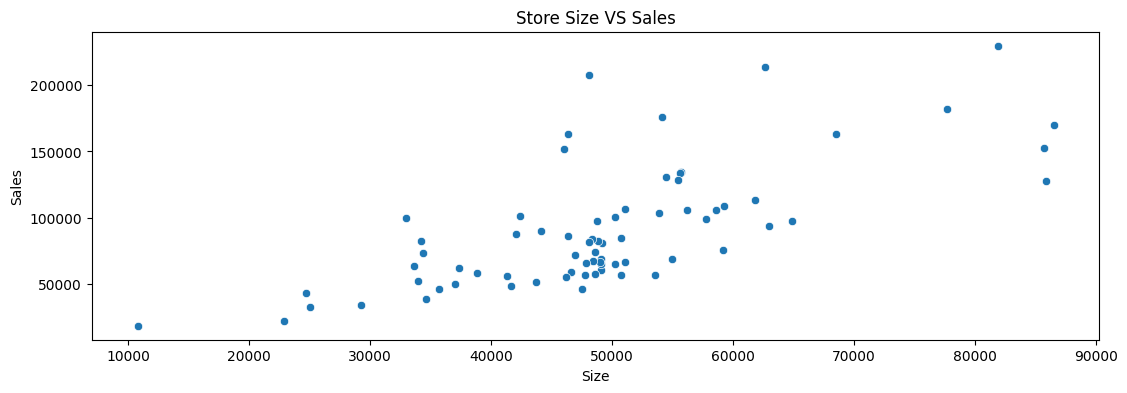

In [ ]:
plt.figure(figsize=(13,4))
sns.scatterplot(x=Store_size['size'], y=Store_size['Sales'])
plt.title('Store Size VS Sales')
plt.xlabel('Size')
plt.ylabel('Sales')
plt.show()

* There is a general positive correlation between store size and sales. Larger stores tend to have higher sales, though the relationship is not perfectly linea

4. **Weekly Baskets Hypothesis**: Stores with higher average weekly baskets sold are expected to have higher overall sales.

In [ ]:
Store_basket='''
select AVG_WEEKLY_BASKETS as basket, sum(UNITS) as Sales
from`my_dataset.complete_data`
 group by basket
 '''
Store_basket=client.query(Store_basket).to_dataframe()

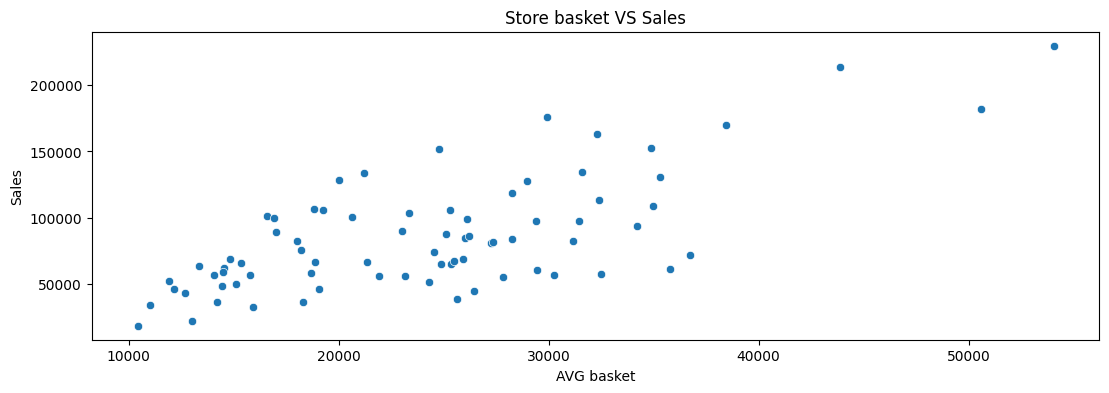

In [ ]:
plt.figure(figsize=(13,4))
sns.scatterplot(x=Store_basket['basket'], y=Store_basket['Sales'])
plt.title('Store basket VS Sales')
plt.xlabel('AVG basket')
plt.ylabel('Sales')
plt.show()

* There is a positive correlation between average basket size and sales. Stores with higher average basket values tend to have higher sales overall.

#Conclusion
## Time Series Analysis:

*  January consistently has the highest sales each year.

* September tends to have the lowest sales.

* There’s a clear weekly seasonality, but no long-term upward or downward trend in sales, except for notable sales spikes during promotional periods (e.g., early 2010).

* Monthly sales exhibit seasonal patterns, with sales peaking in winter months and dipping in late summer and early fall.

* Despite weekly fluctuations, the sales trend remains fairly stable overall.
There is a clear spike in sales in week 60, which is followed by a sharp decline, likely driven by promotions or seasonal effects.

# Product-Level Analysis:

* Cold cereal generates the highest sales, while frozen pizza has comparatively lower sales.
* All Family Cereal dominates sales across sub-categories, leading other cereal types.
* Medium-sized products are the most popular, while larger products do not show significantly higher demand.
* Products that are neither displayed nor featured have higher sales compared to those that are displayed or featured.
* Discounts result in temporary sales spikes, but do not sustain higher overall sales.
* Private Label outperforms major brands, showing that popular manufacturers do not necessarily drive the highest sales.

# Store-Level Analysis:


* HOUSTON has the highest sales across all stores.

* CINCINNATI city leads in overall sales.

* Bigger stores drive higher sales due to increased foot traffic and inventory.

* Stores with higher average weekly baskets also generate higher sales.